In [1]:
import numpy as np
import pickle as pkl
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import matplotlib.patches as patches
import os
import sys
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils
import sklearn
import skimage
from skimage.measure import label, regionprops

# Load dataset

## Without trials

In [2]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums = np.zeros((n_rows, n_cols, n_neurons_v1)) # sum of all spikes per neuron and position
lm_all = np.zeros((n_rows, n_cols, n_neurons_lm)) # sum of all spikes per neuron and position

for col in tqdm(range(n_cols)):
    for row in range(n_rows):
        data_file = 'Data_disconnected/simulation_data_row_'+str(row)+'_col_'+str(col)+'_r10.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(row)+'_'+str(col)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[row, col, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[row, col, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('Data_disconnected/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('Data_disconnected/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [38:41<00:00, 211.09s/it]

Data saved


## With trials

In [3]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums_trials = np.zeros((n_rows, n_cols, n_trials, n_neurons_v1)) # sum of all spikes per neuron and position
lm_all_trials = np.zeros((n_rows, n_cols, n_trials, n_neurons_lm)) # sum of all spikes per neuron and position

for col in tqdm(range(n_cols)):
    for row in range(n_rows):
        data_file = 'Data_disconnected/simulation_data_row_'+str(row)+'_col_'+str(col)+'_r10.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(row)+'_'+str(col)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            for trial in range(n_trials):
                v1_sums_trials[row, col, trial, :] += np.sum(v1[trial, time_bin[0]:time_bin[1]], axis=(0))
                lm_all_trials[row, col, trial, :] += np.sum(lm[trial, time_bin[0]:time_bin[1]], axis=(0))

# save the data
with open('Data_disconnected/v1_sums_trials.pkl', 'wb') as f:
    pkl.dump(v1_sums_trials, f)

with open('Data_disconnected/lm_sums_trials.pkl', 'wb') as f:
     pkl.dump(lm_all_trials, f)

print('Data saved')

# remember v1 and lm are structured as (trials, time, neurons)

time-steps of stimulus 1000


100%|██████████| 11/11 [37:20<00:00, 203.71s/it]


Data saved


# Plot RF for individual neurons

## Raster plot

In [2]:
n_trials = 50
n_cols = 1 #11
n_rows = 1 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_trials = np.zeros((n_rows, n_cols, n_trials, n_timesteps, n_neurons_v1)) # all spikes per neuron and position

time-steps of stimulus 1000


In [ ]:
for col in tqdm(range(n_cols)):
    for row in range(n_rows):
        data_file = 'Data_50trials/simulation_data_row_'+str(row)+'_col_'+str(col)+'.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(row)+'_'+str(col)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for i, time_bin in enumerate(time_bins):
            for trial in range(n_trials):
                v1_trials[row, col, trial, i*250:(i+1)*250] += v1[trial, time_bin[0]:time_bin[1]]
                # lm_all_trials[row, col, trial, :] += np.sum(lm[trial, time_bin[0]:time_bin[1]], axis=(0))

# save the data
with open('Data_50trials/v1_1pos.pickle', 'wb') as f:
    pkl.dump(v1_trials, f)

# with open('Data_50trials/lm_sums_trials.pkl', 'wb') as f:
#      pkl.dump(lm_all_trials, f)

print('Data saved')

In [ ]:
# Do the raster plot
# load the data
with open('Data_50trials/v1_1pos.pickle', 'rb') as f:
    v1_trials = pkl.load(f)

# select the neuron
neuron = 10000
data = v1_trials[0, 0, :, :, neuron]

# plot the raster with scatter
plt.figure(figsize=(6, 7), dpi=100)
plt.scatter(np.where(data == 1)[1], np.where(data == 1)[0], s=4, color = 'k')
for i in range(0, data.shape[1], 250):
    plt.axvline(x=i, color='goldenrod', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Trials')
plt.title('Raster plot of neuron '+str(neuron))
plt.show()

## Plot RF

In [23]:
# select a neuron
neuron_id = 17342 #2342

# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414

# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])

# load the data
with open('Data_connected/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_connected/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

with open('Data_disconnected/v1_sums.pkl', 'rb') as f:
     v1_sums_dis = pkl.load(f)

# select disconnected or connected
# v1_sums = v1_sums_dis
# lm_all = lm_all_dis

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000
v1_sums_dis = v1_sums_dis / (n_trials * n_timesteps) * 1000

# get neuron's position
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# filter only core neurons that follow r = np.sqrt(x ** 2 + z ** 2) < 400
r = np.sqrt(v1_positions_x ** 2 + v1_positions_z ** 2)
selected_mask = r < 400
v1_positions_x_core = v1_positions_x[selected_mask]
v1_positions_z_core = v1_positions_z[selected_mask]

# get the position of the neuron
neuron_pos = v1_positions_x_core[neuron_id], v1_positions_z_core[neuron_id]

neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space

print('Neuron position:', neuron_pos)

# obtain an array with all neurons positions
neurons_positions = np.zeros((n_neurons_v1, 2))
for id in range(n_neurons_v1):
    neuron_pos = v1_positions_x_core[id], v1_positions_z_core[id]
    neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space
    neurons_positions[id] = neuron_pos

# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

# get the neuron type of the selected neuron
neuron_type = cell_types_v1[neuron_id]

print('Neuron type:', neuron_type)

Neuron position: (5.927044563293457, 6.868526245117188)
Neuron type: L2/3 Exc


Expected value: 0.5199999999999999
std: 0.08071784155154656
Minimum value: 0.5199999999999999
threshold: 0.11641079224226714


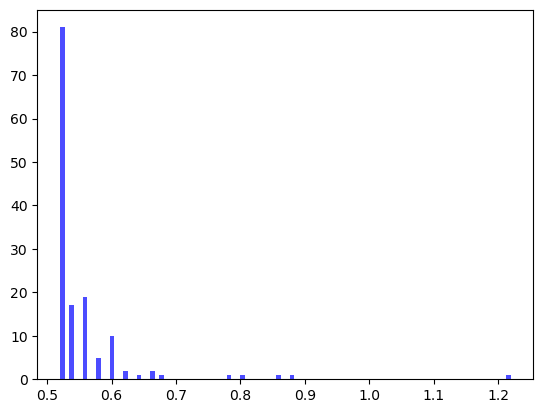

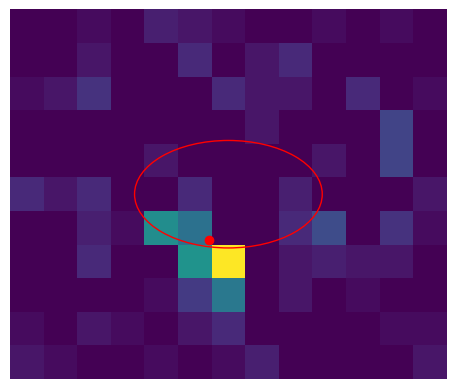

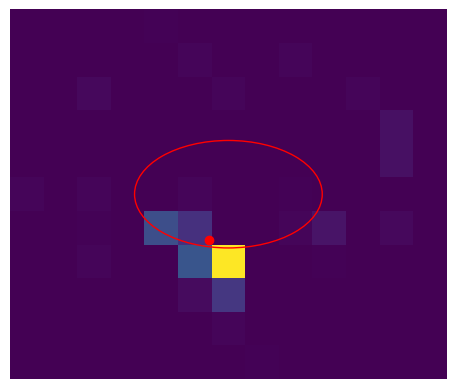


Max residual value: 0.7000000000000001


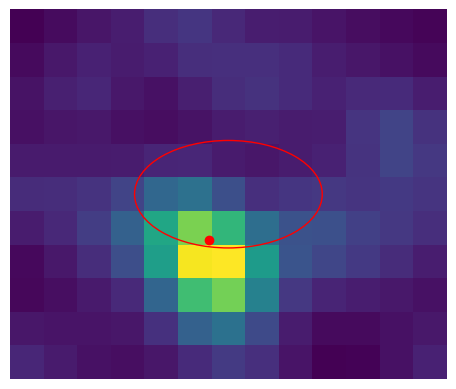

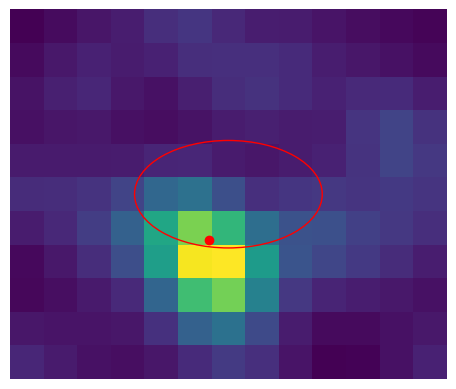

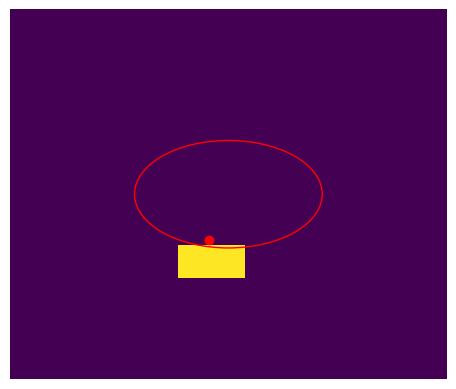


Area: 2
Area threshold: 0.6908281383338163


In [24]:
# select the given neuron
v1_neuron = np.copy(v1_sums[:,:,neuron_id]) # 1

percentile_5 = np.percentile(v1_neuron, 2.5)
percentile_95 = np.percentile(v1_neuron, 97.5)
percentile_median = np.median(v1_neuron[(v1_neuron > percentile_5) & (v1_neuron < percentile_95)])
# set 0.0 values to percentile median
v1_neuron[np.round(v1_neuron) == 0.0] = percentile_median

expected_value = np.median(v1_neuron)
print("Expected value:", expected_value)
print("std:", np.std(v1_neuron))

# plot histogram of the neuron
plt.figure()
plt.hist(v1_neuron.flatten(), bins=100, color='b', alpha=0.7)
print("Minimum value:", np.min(v1_neuron))

# set to expected value all the values below a th
th = expected_value - 5*np.std(v1_neuron)
v1_neuron[v1_neuron < th] = expected_value

print("threshold:", th)
# print("std", std)

# plot without gaussian filter
plt.figure()
ax = sns.heatmap(v1_neuron.T, cmap='viridis', square=True, cbar = False)

# # Get the colorbar from the Heatmap
# cbar = ax.collections[0].colorbar

# # Here you can set the label size by 20
# cbar.set_label("Average firing rate (Hz)", size=14)

# # Here you can set the tick labels font size by 15
# cbar.ax.tick_params(labelsize=13)

# plt.xlabel('Column')
# plt.ylabel('Row')

# remove axis and color bar
plt.axis('off')

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels);
ax.set_yticklabels(ylabels);

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
neuron_pos = neurons_positions[neuron_id]
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

# check if it's inverse
expected = np.median(v1_neuron)
residuals = (v1_neuron - expected)**2

# plot heatmap of residuals
plt.figure()
ax = sns.heatmap(residuals.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
plt.axis('off')

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

# check the rf value at the max residual point
max_residual = np.max(residuals)
max_residual_idx = np.where(residuals == max_residual)
max_residual_value = v1_neuron[max_residual_idx][0]
max_residual_value -= expected_value # <0 if inverse RF

print('\nMax residual value:', max_residual_value)

# plot gaussian filter before reversing
v1_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
plt.figure()
ax = sns.heatmap(v1_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

plt.axis('off')

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

if max_residual_value < 0:
    smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
    v1_neuron_smooth = np.max(smooth_rf) - smooth_rf

    print("inverse neuron")
else:
    v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

# plot the receptive field as a heatmap
plt.figure()
ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False) 

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

plt.axis('off')

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

# now apply the threshold at max(RF) – std(RF)
threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

# plot the thresholded receptive field
plt.figure()
ax = sns.heatmap(v1_neuron_thresholded.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

plt.axis('off')

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

# compute the area of the thresholded RF
# select the largest connected component
neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)

area = np.sum(v1_neuron_thresholded)
print('\nArea:', area)
print('Area threshold:', threshold)

#### Test

Expected value: 0.5199999999999999
std: 0.08071784155154656
mad: 0.0
Minimum value: 0.5199999999999999
Positions above std: (array([0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 7]), array([ 5,  9, 10,  5, 10,  5,  6,  7,  9,  6,  9,  4,  6,  8, 10,  5,  6,
        7,  8,  9,  7,  8,  9, 10, 10]))
Length above std: 25
Non-inverse RF


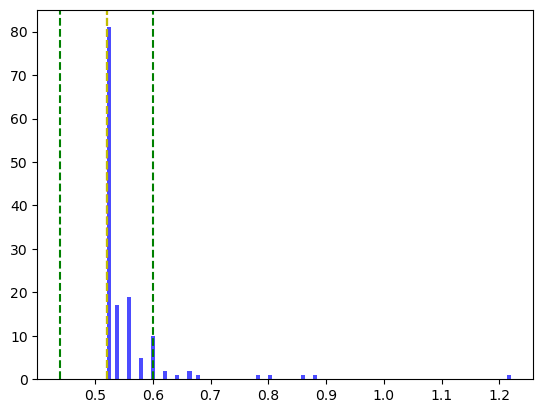

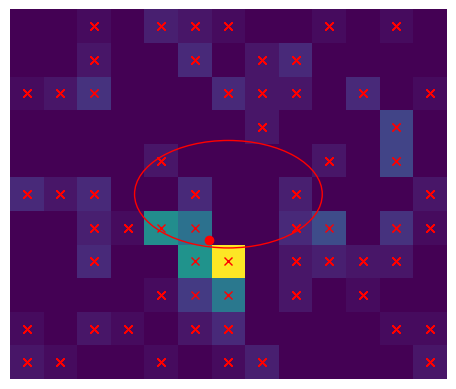

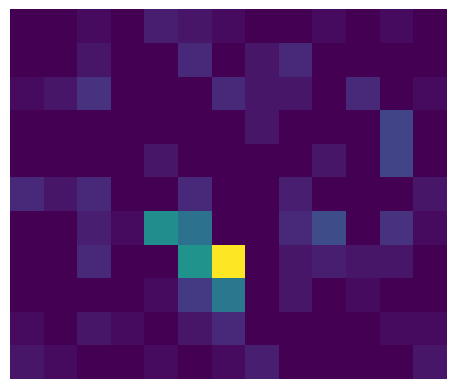

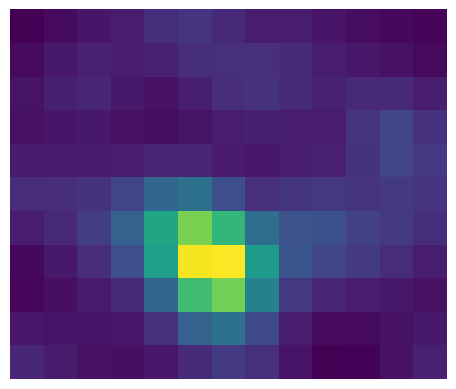

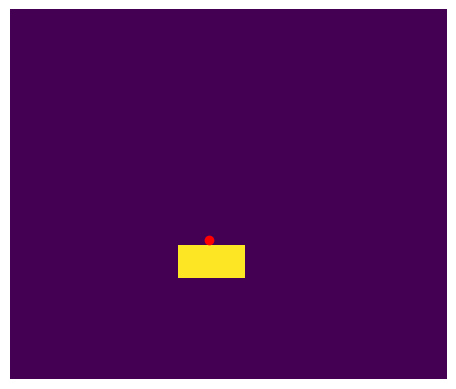


Area: 2
Area threshold: 0.6908281383338163


In [26]:
# select the given neuron
v1_neuron = np.copy(v1_sums[:,:,neuron_id]) # 1

# set 0.0 values to percentile median
expected_value = np.median(v1_neuron)
v1_neuron[np.round(v1_neuron) == 0.0] = expected_value

expected_value = np.median(v1_neuron)
std = np.std(v1_neuron)
mad = np.median(np.abs(v1_neuron - expected_value))
print("Expected value:", expected_value)
print("std:", std)
print("mad:", mad)

# plot histogram of the neuron
plt.figure()
plt.hist(v1_neuron.flatten(), bins=100, color='b', alpha=0.7)
print("Minimum value:", np.min(v1_neuron))
# plot mean and std
plt.axvline(expected_value, color='r', linestyle='--')
plt.axvline(expected_value + std, color='g', linestyle='--')
plt.axvline(expected_value - std, color='g', linestyle='--')
plt.axvline(expected_value + mad*3.5, color='y', linestyle='--')
plt.axvline(expected_value - mad*3.5, color='y', linestyle='--')

# obtain list of positions above and below the std
above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]

# create two new heatmaps with 1 in the given positions and 0 in the rest of them
above_std_map_binary = np.zeros(v1_neuron.shape)
below_std_map_binary = np.zeros(v1_neuron.shape)
# merge
above_below_std = np.concatenate((above_std, below_std))

if len(above_std) > 0:
    for i in range(len(above_std)):
        idx = np.where(v1_neuron == above_std[i])
        above_std_map_binary[idx] = 1

    # labelling connected components
    above_std_map = skimage.measure.label(above_std_map_binary)
    # get the largest connected component of each map
    above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
    # get the list of positions
    above_std_positions_largest = np.where(above_std_map == 1)
    # print the positions
    print('Positions above std:', above_std_positions_largest)
    # compare lengths of above and below std
    print('Length above std:', len(above_std_positions_largest[0]))
else:
    above_std_positions_largest = [[]]

if len(below_std) > 0:
    for i in range(len(below_std)):
        idx = np.where(v1_neuron == below_std[i])
        below_std_map_binary[idx] = 1

    below_std_map = skimage.measure.label(below_std_map_binary)
    below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
    below_std_positions_largest = np.where(below_std_map == 1)
    print('Positions below std:', below_std_positions_largest)
    print('Length below std:', len(below_std_positions_largest[0]))
else:
    below_std_positions_largest = [[]]

if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
    inverse = True
    print('Inverse RF')
else:
    inverse = False
    print('Non-inverse RF')

# plot without gaussian filter
plt.figure()
ax = sns.heatmap(v1_neuron.T, cmap='viridis', square=True, cbar = False)

# add a cross at positions in above_below_std list
for i in range(len(above_below_std)):
    idx = np.where(v1_neuron == above_below_std[i])
    plt.plot(idx[0]+0.5, idx[1]+0.5, 'rx')

# remove axis and color bar
plt.axis('off')

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels);
ax.set_yticklabels(ylabels);

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
neuron_pos = neurons_positions[neuron_id]
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

if inverse:
    # obtain lists of the positions of all the connected components
    connected_components = label(below_std_map_binary)

    # Identify the largest connected component
    largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

    # Create a mask for the largest connected component and set it to 0
    below_std_map_binary[connected_components == largest_cc_label] = 0

    mask = (below_std_map_binary == 1)
    outlier_values = v1_neuron[mask]

    threshold = np.max(outlier_values)

    # set values below or equal to threshold to the median
    v1_neuron[v1_neuron <= threshold] = expected_value

    # plot the RF
    plt.figure()
    ax = sns.heatmap(v1_neuron.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

    smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
    # plot the smoothed RF
    # plt.figure()
    # ax = sns.heatmap(smooth_rf.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    # plt.axis('off')

    v1_neuron_smooth = np.max(smooth_rf) - smooth_rf
    print("inverse neuron")

    # plot the smoothed RF
    plt.figure()
    ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')
else:
    connected_components = label(below_std_map_binary)

    mask = (below_std_map_binary == 1)
    outlier_values = v1_neuron[mask]

    if len(outlier_values>0):
        threshold = np.max(outlier_values)
    else:
        threshold = 0

    # set values below or equal to threshold to the median
    v1_neuron[v1_neuron <= threshold] = expected_value

    # plot the RF
    plt.figure()
    ax = sns.heatmap(v1_neuron.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

    v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # plot the smoothed RF
    plt.figure()
    ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

# now apply the threshold at max(RF) – std(RF)
threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

# plot the thresholded receptive field
plt.figure()
ax = sns.heatmap(v1_neuron_thresholded.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

plt.axis('off')

# # plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

# compute the area of the thresholded RF
# select the largest connected component
neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)

area = np.sum(v1_neuron_thresholded)
print('\nArea:', area)
print('Area threshold:', threshold)

# Compute RF all neurons

1. Identify inverse RF neurons
2. Invert they RF
3. Compute RF area to all neurons by removing low outliers

In [4]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414

# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])

# load the data
with open('Data_connected/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_connected/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

with open('Data_disconnected/v1_sums.pkl', 'rb') as f:
    v1_sums_dis = pkl.load(f)

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000
v1_sums_dis = v1_sums_dis / (n_trials * n_timesteps) * 1000

In [5]:
# V1
rf_areas_v1 = np.zeros((n_neurons_v1))
inverse_indices_v1 = []

for neuron in tqdm(range(n_neurons_v1)):
    # select the given neuron
    v1_neuron = np.copy(v1_sums[:,:,neuron])

    percentil5 = np.percentile(v1_neuron, 2.5)
    percentil95 = np.percentile(v1_neuron, 97.5)
    percentil_median = np.median(v1_neuron[(v1_neuron > percentil5) & (v1_neuron < percentil95)])
    # set 0.0 values to percentile median
    v1_neuron[np.round(v1_neuron) == 0.0] = percentil_median

    # compute expected value set outliers to expected value
    expected_value = np.median(v1_neuron)
    th = expected_value - 5*np.std(v1_neuron)
    v1_neuron[v1_neuron < th] = expected_value

    # compute residuals
    residuals = (v1_neuron - expected_value)**2

    # check the rf value at the max residual point
    max_residual = np.max(residuals)
    max_residual_idx = np.where(residuals == max_residual)
    if expected_value > 0:
        max_residual_value = v1_neuron[max_residual_idx][0]
        max_residual_value -= expected_value # <0 if inverse RF
    else:
        max_residual_value = 0

    if max_residual_value < 0:
        inverse_indices_v1.append(neuron)
        smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
        gaussian_rf = np.max(smooth_rf) - smooth_rf

    else:
        # remove very low outliers
        # Apply Gaussian filter
        gaussian_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # apply threshold
    threshold = np.max(gaussian_rf) - np.std(gaussian_rf)
    v1_neuron_thresholded = np.zeros(gaussian_rf.shape)
    v1_neuron_thresholded[gaussian_rf > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
    try:
        v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        v1_neuron_thresholded = np.zeros(gaussian_rf.shape)

    rf_areas_v1[neuron] = np.sum(v1_neuron_thresholded)*100

    if rf_areas_v1[neuron] > 2500 or rf_areas_v1[neuron] <= 0:
        # set to nan
        rf_areas_v1[neuron] = np.nan

# LM
inverse_indices_lm = []
rf_areas_lm = np.zeros((n_neurons_lm))

for neuron in tqdm(range(n_neurons_lm)):
    # select the given neuron
    lm_neuron = np.copy(lm_all[:,:,neuron])

    percentile_5 = np.percentile(lm_neuron, 2.5)
    percentile_95 = np.percentile(lm_neuron, 97.5)
    percentile_median = np.median(lm_neuron[(lm_neuron > percentile_5) & (lm_neuron < percentile_95)])
    # set 0.0 values to percentile median
    lm_neuron[np.round(lm_neuron) == 0.0] = percentile_median

    # set outliers to median
    expected_value = np.median(lm_neuron)
    th = expected_value - 5*np.std(lm_neuron)
    lm_neuron[lm_neuron < th] = expected_value

    # compute residuals
    residuals = (lm_neuron - expected_value)**2

    # check the rf value at the max residual point
    max_residual = np.max(residuals)
    max_residual_idx = np.where(residuals == max_residual)
    if expected_value > 0:
        max_residual_value = lm_neuron[max_residual_idx][0]
    else:
        max_residual_value = 0
    
    max_residual_value -= expected_value # <0 if inverse RF

    if max_residual_value < 0:
        inverse_indices_lm.append(neuron)
        smooth_rf = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)
        gaussian_rf = np.max(smooth_rf) - smooth_rf

    else:
        # Apply Gaussian filter
        gaussian_rf = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

    # apply threshold
    threshold = np.max(gaussian_rf) - np.std(gaussian_rf)
    lm_neuron_thresholded = np.zeros(gaussian_rf.shape)
    lm_neuron_thresholded[gaussian_rf > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(lm_neuron_thresholded)
    try:
        lm_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        lm_neuron_thresholded = np.zeros(gaussian_rf.shape)

    rf_areas_lm[neuron] = np.sum(lm_neuron_thresholded)*100

    if rf_areas_lm[neuron] > 2500 or rf_areas_lm[neuron] <= 0:
        # set to nan
        rf_areas_lm[neuron] = np.nan

# V1 disconnected
rf_areas_v1_dis = np.zeros((n_neurons_v1))
inverse_indices_v1_dis = []

for neuron in tqdm(range(n_neurons_v1)):
    # select the given neuron
    v1_neuron = np.copy(v1_sums_dis[:,:,neuron])

    percentile_5 = np.percentile(v1_neuron, 2.5)
    percentile_95 = np.percentile(v1_neuron, 97.5)
    percentile_median = np.median(v1_neuron[(v1_neuron > percentile_5) & (v1_neuron < percentile_95)])
    # set 0.0 values to percentile median
    v1_neuron[np.round(v1_neuron) == 0.0] = percentile_median

    # compute expected value
    expected_value = np.median(v1_neuron)
     # remove very low outliers
    th = expected_value - 5*np.std(v1_neuron)
    v1_neuron[v1_neuron < th] = expected_value

    new_expected_value = np.median(v1_neuron)

    residuals = (v1_neuron - new_expected_value)**2

    # check the rf value at the max residual point
    max_residual = np.max(residuals)
    max_residual_idx = np.where(residuals == max_residual)
    if expected_value > 0:
        max_residual_value = v1_neuron[max_residual_idx][0]
    else:
        max_residual_value = 0
    
    max_residual_value -= new_expected_value # <0 if inverse RF

    if neuron in inverse_indices_v1:
        inverse_indices_v1_dis.append(neuron)
        smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
        gaussian_rf = np.max(smooth_rf) - smooth_rf

    else:
        # Apply Gaussian filter
        gaussian_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # apply threshold
    threshold = np.max(gaussian_rf) - np.std(gaussian_rf)
    v1_neuron_thresholded = np.zeros(gaussian_rf.shape)
    v1_neuron_thresholded[gaussian_rf > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
    try:
        v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        v1_neuron_thresholded = np.zeros(gaussian_rf.shape)

    rf_areas_v1_dis[neuron] = np.sum(v1_neuron_thresholded)*100

    if rf_areas_v1_dis[neuron] > 2500 or rf_areas_v1_dis[neuron] <= 0:
        # set to nan
        rf_areas_v1_dis[neuron] = np.nan

# save the data
with open('rf_areas_v1.pkl', 'wb') as f:
    pkl.dump(rf_areas_v1, f)

with open('rf_areas_lm.pkl', 'wb') as f:
    pkl.dump(rf_areas_lm, f)

with open('rf_areas_v1_dis.pkl', 'wb') as f:
    pkl.dump(rf_areas_v1_dis, f)

  0%|          | 255/51978 [00:00<00:59, 866.66it/s]

 11%|█▏        | 5966/51978 [00:03<00:22, 2027.96it/s]/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 51978/51978 [00:30<00:00, 1679.48it/s]


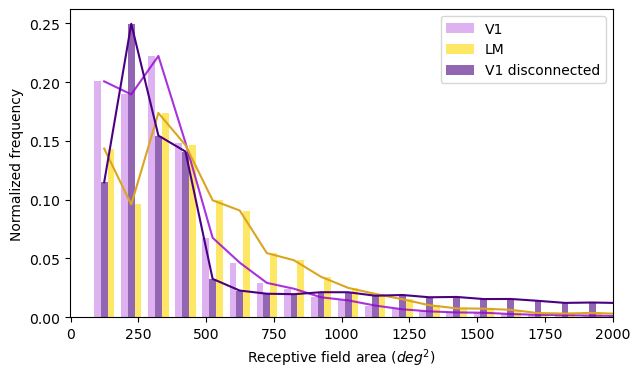

V1 median: 300.0
LM median: 400.0
V1 disconnected median: 300.0

V1 mean: 373.1133451299901
LM mean: 510.1673813805506
V1 disconnected mean: 610.0017969451932


In [6]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,4))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Normalized frequency')
plt.xlim(-1, 2000)
plt.legend()
plt.show()

# print the medians
print('V1 median:', np.nanmedian(rf_areas_v1))
print('LM median:', np.nanmedian(rf_areas_lm))
print('V1 disconnected median:', np.nanmedian(rf_areas_v1_dis))

# print the means
print()
print('V1 mean:', np.nanmean(rf_areas_v1))
print('LM mean:', np.nanmean(rf_areas_lm))
print('V1 disconnected mean:', np.nanmean(rf_areas_v1_dis))

# # compute 5th and 95th percentiles
# q5_v1 = np.percentile(rf_areas_v1, 5)
# q95_v1 = np.percentile(rf_areas_v1, 95)
# q5_lm = np.percentile(rf_areas_lm, 5)
# q95_lm = np.percentile(rf_areas_lm, 95)
# q5_v1dis = np.percentile(rf_areas_v1_dis, 5)
# q95_v1dis = np.percentile(rf_areas_v1_dis, 95)

# # print the mean of the data within the 5th and 95th percentiles
# print()
# print('V1 mean within 5th and 95th percentiles:', np.nanmean(rf_areas_v1[(rf_areas_v1 > q5_v1) & (rf_areas_v1 < q95_v1)]))
# print('LM mean within 5th and 95th percentiles:', np.nanmean(rf_areas_lm[(rf_areas_lm > q5_lm) & (rf_areas_lm < q95_lm)]))
# print('V1 disconnected mean within 5th and 95th percentiles:', np.nanmean(rf_areas_v1_dis[(rf_areas_v1_dis > q5_v1dis) & (rf_areas_v1_dis < q95_v1dis)]))

## By neuron type

In [7]:
# Now do it again but selecting only neurons from a given type
# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]
new_pop_names = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=7414, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_lm = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_v1] for i in range(len(unique_cell_types))]
layer_mask_lm_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_lm] for i in range(len(unique_cell_types))]

# Select the neuron type to filter
t = 9
type = unique_cell_types[t]
print("You have selected the type: ", type)

# select the given neuron type receptive field
rf_areas_type_v1 = rf_areas_v1[layer_mask_v1_types[t]]
rf_areas_type_lm = rf_areas_lm[layer_mask_lm_types[t]]
rf_areas_type_v1_dis = rf_areas_v1_dis[layer_mask_v1_types[t]]

You have selected the type:  L5 Exc


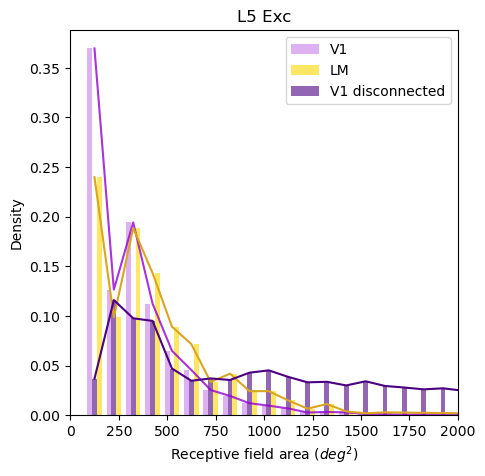

Median V1 RF area: 300.0
Median LM RF area: 300.0
Median V1 disconnected RF area: 900.0

Mean V1 RF area: 307.4358295845462
Mean LM RF area: 408.92193308550185
Mean V1 disconnected RF area: 988.3001049317943


In [8]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_type_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_type_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_type_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (5,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title(type)
plt.legend()
plt.show()

# print the medians
print('Median V1 RF area:', np.nanmedian(rf_areas_type_v1))
print('Median LM RF area:', np.nanmedian(rf_areas_type_lm))
print('Median V1 disconnected RF area:', np.nanmedian(rf_areas_type_v1_dis))

# print the means
print()
print('Mean V1 RF area:', np.nanmean(rf_areas_type_v1))
print('Mean LM RF area:', np.nanmean(rf_areas_type_lm))
print('Mean V1 disconnected RF area:', np.nanmean(rf_areas_type_v1_dis))

# # compute 5th and 95th percentiles
# q5_v1 = np.percentile(rf_areas_type_v1, 5)
# q95_v1 = np.percentile(rf_areas_type_v1, 95)
# q5_lm = np.percentile(rf_areas_type_lm, 5)
# q95_lm = np.percentile(rf_areas_type_lm, 95)
# q5_v1dis = np.percentile(rf_areas_type_v1_dis, 5)
# q95_v1dis = np.percentile(rf_areas_type_v1_dis, 95)

# # print the mean of the data within the 5th and 95th percentiles
# print()
# print('V1 mean within 5th and 95th percentiles:', np.mean(rf_areas_type_v1[(rf_areas_type_v1 > q5_v1) & (rf_areas_type_v1 < q95_v1)]))
# print('LM mean within 5th and 95th percentiles:', np.mean(rf_areas_type_lm[(rf_areas_type_lm > q5_lm) & (rf_areas_type_lm < q95_lm)]))
# print('V1 disconnected mean within 5th and 95th percentiles:', np.mean(rf_areas_type_v1_dis[(rf_areas_type_v1_dis > q5_v1dis) & (rf_areas_type_v1_dis < q95_v1dis)]))

## For all excitatory neurons

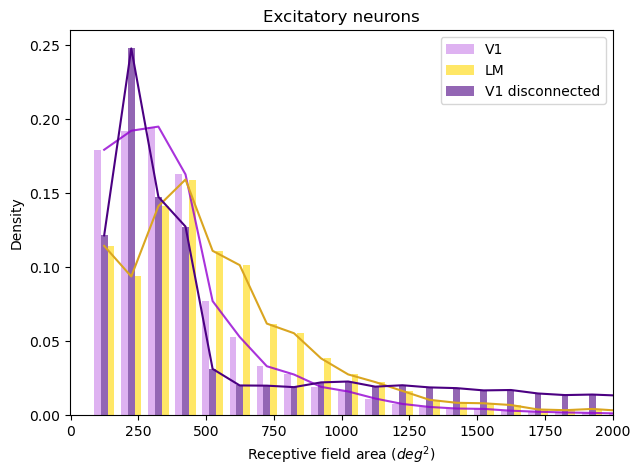

Median V1 RF area: 300.0
Median LM RF area: 400.0
Median V1 disconnected RF area: 300.0

Mean V1 RF area: 394.03228816722657
Mean LM RF area: 543.3355548150616
Mean V1 disconnected RF area: 634.4598862918509


In [9]:
# Now do it for all excitatory neurons together: L2/3 Exc, L4 Exc, L5 Exc, L6 Exc
types = [1, 5, 9, 13]

rf_areas_exc_v1 = np.zeros((0))
rf_areas_exc_lm = np.zeros((0))
rf_areas_exc_v1_dis = np.zeros((0))

for t in types:
    rf_areas_exc_v1 = np.concatenate((rf_areas_exc_v1, rf_areas_v1[layer_mask_v1_types[t]]))
    rf_areas_exc_lm = np.concatenate((rf_areas_exc_lm, rf_areas_lm[layer_mask_lm_types[t]]))
    rf_areas_exc_v1_dis = np.concatenate((rf_areas_exc_v1_dis, rf_areas_v1_dis[layer_mask_v1_types[t]]))

# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_exc_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_exc_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_exc_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title('Excitatory neurons')
plt.legend()

# # compute quartile 1 and 3
# q1_v1 = np.percentile(rf_areas_exc_v1, 5)
# q3_v1 = np.percentile(rf_areas_exc_v1, 95)
# q1_lm = np.percentile(rf_areas_exc_lm, 5)
# q3_lm = np.percentile(rf_areas_exc_lm, 95)
# q1_v1dis = np.percentile(rf_areas_exc_v1_dis, 5)
# q3_v1dis = np.percentile(rf_areas_exc_v1_dis, 95)

plt.show()

# print medians
print('Median V1 RF area:', np.nanmedian(rf_areas_exc_v1))
print('Median LM RF area:', np.nanmedian(rf_areas_exc_lm))
print('Median V1 disconnected RF area:', np.nanmedian(rf_areas_exc_v1_dis))

# # print average inside the 1st and 3rd quartile
# print()
# print('Average V1 RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_v1[(rf_areas_exc_v1 > q1_v1) & (rf_areas_exc_v1 < q3_v1)]))
# print('Average LM RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_lm[(rf_areas_exc_lm > q1_lm) & (rf_areas_exc_lm < q3_lm)]))
# print('Average V1 disconnected RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_v1_dis[(rf_areas_exc_v1_dis > q1_v1dis) & (rf_areas_exc_v1_dis < q3_v1dis)]))

# print the means
print()
print('Mean V1 RF area:', np.nanmean(rf_areas_exc_v1))
print('Mean LM RF area:', np.nanmean(rf_areas_exc_lm))
print('Mean V1 disconnected RF area:', np.nanmean(rf_areas_exc_v1_dis))

# Null model and selection of significant neurons

Shuffling with replacement across trials and locations

In [10]:
# Load the data
with open('Data_connected/v1_sums_trials.pkl', 'rb') as f:
    v1_sums_trials = pkl.load(f)

with open('Data_connected/lm_sums_trials.pkl', 'rb') as f:
    lm_all_trials = pkl.load(f)

with open('Data_connected/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

with open('Data_connected/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_disconnected/v1_sums.pkl', 'rb') as f:
    v1_sums_dis = pkl.load(f)

with open('Data_disconnected/v1_sums_trials.pkl', 'rb') as f:
    v1_sums_trials_dis = pkl.load(f)

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000
v1_sums_dis = v1_sums_dis / (n_trials * n_timesteps) * 1000

v1_sums_trials = v1_sums_trials / (n_timesteps) * 1000
lm_all_trials = lm_all_trials / (n_timesteps) * 1000
v1_sums_trials_dis = v1_sums_trials_dis / (n_timesteps) * 1000

## Visualization for 1 neuron

Threshold 3.8324577542673364
Chi2: 0.537794117647058
Chi2 shuffled: 0.9654320987654319


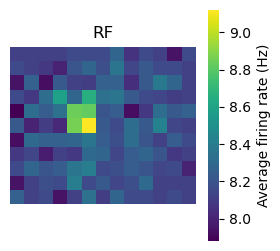

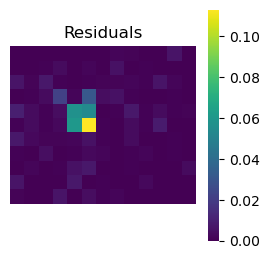

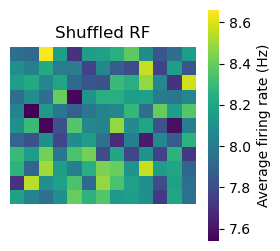

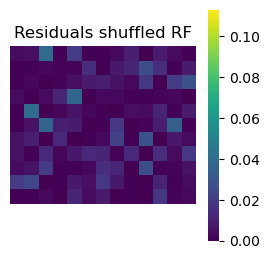

In [12]:
neuron_id = 2342 # try 

neuron_rf = np.copy(v1_sums[:,:,neuron_id]) # select the neuron
neuron_rf_trials = v1_sums_trials[:,:,:,neuron_id] # select the neuron

percentile_5 = np.percentile(neuron_rf, 2.5)
percentile_95 = np.percentile(neuron_rf, 97.5)
percentile_median = np.median(neuron_rf[(neuron_rf > percentile_5) & (neuron_rf < percentile_95)])
# set 0.0 values to percentile median
neuron_rf[np.round(neuron_rf) == 0.0] = percentile_median

# compute expected value
expected_value = np.median(neuron_rf)
th = expected_value - 5*np.std(neuron_rf)
neuron_rf[neuron_rf < th] = expected_value

# compute residuals
residuals = (neuron_rf - expected_value)**2 / expected_value
max_residuals = np.max(residuals)

print("Threshold", th)

# plot without gaussian filter
plt.figure(figsize =(3,3))
ax = sns.heatmap(neuron_rf.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True)
plt.title('RF')
plt.axis('off')

# plot the residuals
plt.figure(figsize=(3,3))
ax = sns.heatmap(residuals.T, cmap='viridis', square = True)
plt.title('Residuals')
plt.axis('off')

# compute chi^2
chi2 = np.sum(residuals)
print('Chi2:', chi2)

# now compute RF shuffling every position in each trial and then computing the average over trials
n_shuffles = 1

for i in range(n_shuffles):
    # create a matrix to store the shuffled RFs
    shuffled_rf = np.zeros((n_rows, n_cols))

    flattened_arr = neuron_rf_trials.flatten()
    bootstrap_sample = np.random.choice(flattened_arr, size=flattened_arr.size, replace=True)
    bootstrap_arr = bootstrap_sample.reshape(neuron_rf_trials.shape)

    shuffled_rf = np.mean(bootstrap_arr, axis = 2)

    # set to the median all the values below a th
    percentile_5 = np.percentile(shuffled_rf, 2.5)
    percentile_95 = np.percentile(shuffled_rf, 97.5)
    percentile_median = np.median(shuffled_rf[(shuffled_rf > percentile_5) & (shuffled_rf < percentile_95)])
    # set 0.0 values to percentile median
    shuffled_rf[np.round(shuffled_rf) == 0.0] = percentile_median

    # compute expected value
    expected_value = np.median(shuffled_rf)
    th = expected_value - 5*np.std(shuffled_rf)
    shuffled_rf[shuffled_rf < th] = expected_value

    # compute residuals
    residuals = (shuffled_rf - expected_value)**2 / expected_value

    # plot the shuffled RFs
    plt.figure(figsize =(3,3))
    ax = sns.heatmap(shuffled_rf.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True)
    plt.title('Shuffled RF')
    plt.axis('off')

    # plot the residuals
    plt.figure(figsize=(3,3))
    ax = sns.heatmap(residuals.T, cmap='viridis', square = True, vmax = max_residuals)
    plt.title('Residuals shuffled RF')
    plt.axis('off')

    # compute chi^2
    chi2_null = np.sum(residuals)
    print('Chi2 shuffled:', chi2_null)


## Null model for all neurons

In [36]:
n_shuffles = 10

In [37]:
# V1
real_chi2_v1 = np.zeros((n_neurons_v1))
null_chi2_v1 = np.zeros((n_neurons_v1, n_shuffles))

for neuron in tqdm(range(n_neurons_v1)):
    neuron_rf = np.copy(v1_sums[:,:,neuron]) # select the neuron
    neuron_rf_trials = v1_sums_trials[:,:,:,neuron] # select the neuron

    percentile_5 = np.percentile(neuron_rf, 2.5)
    percentile_95 = np.percentile(neuron_rf, 97.5)
    percentile_median = np.median(neuron_rf[(neuron_rf > percentile_5) & (neuron_rf < percentile_95)])
    # set 0.0 values to percentile median
    neuron_rf[np.round(neuron_rf) == 0.0] = percentile_median

    # compute expected value
    expected_value = np.median(neuron_rf)
    th = expected_value - 5*np.std(neuron_rf)
    neuron_rf[neuron_rf < th] = expected_value

    # compute residuals
    residuals = (neuron_rf - expected_value)**2 / expected_value
    max_residuals = np.max(residuals)

    # compute chi^2
    real_chi2_v1[neuron] = np.sum(residuals)

    for i in range(n_shuffles):
        # create a matrix to store the shuffled RFs
        shuffled_rf = np.zeros((n_rows, n_cols))

        flattened_arr = neuron_rf_trials.flatten()
        bootstrap_sample = np.random.choice(flattened_arr, size=flattened_arr.size, replace=True)
        bootstrap_arr = bootstrap_sample.reshape(neuron_rf_trials.shape)

        shuffled_rf = np.mean(bootstrap_arr, axis = 2)

        # set to the median all the values below a th
        percentile_5 = np.percentile(shuffled_rf, 2.5)
        percentile_95 = np.percentile(shuffled_rf, 97.5)
        percentile_median = np.median(shuffled_rf[(shuffled_rf > percentile_5) & (shuffled_rf < percentile_95)])
        # set 0.0 values to percentile median
        shuffled_rf[np.round(shuffled_rf) == 0.0] = percentile_median

        # compute expected value
        expected_value = np.median(shuffled_rf)
        th = expected_value - 5*np.std(shuffled_rf)
        shuffled_rf[shuffled_rf < th] = expected_value

        # compute residuals
        residuals = (shuffled_rf - expected_value)**2 / expected_value

        # compute chi^2
        null_chi2_v1[neuron, i] = np.sum(residuals)

# LM
real_chi2_lm = np.zeros((n_neurons_lm))
null_chi2_lm = np.zeros((n_neurons_lm, n_shuffles))

for neuron in tqdm(range(n_neurons_lm)):
    neuron_rf = np.copy(lm_all[:,:,neuron]) # select the neuron
    neuron_rf_trials = lm_all_trials[:,:,:,neuron] # select the neuron

    percentile_5 = np.percentile(neuron_rf, 2.5)
    percentile_95 = np.percentile(neuron_rf, 97.5)
    percentile_median = np.median(neuron_rf[(neuron_rf > percentile_5) & (neuron_rf < percentile_95)])
    # set 0.0 values to percentile median
    neuron_rf[np.round(neuron_rf) == 0.0] = percentile_median

    # compute expected value
    expected_value = np.median(neuron_rf)
    th = expected_value - 5*np.std(neuron_rf)
    neuron_rf[neuron_rf < th] = expected_value

    # compute residuals
    residuals = (neuron_rf - expected_value)**2 / expected_value
    max_residuals = np.max(residuals)

    # compute chi^2
    real_chi2_lm[neuron] = np.sum(residuals)

    for i in range(n_shuffles):
        # create a matrix to store the shuffled RFs
        shuffled_rf = np.zeros((n_rows, n_cols))

        flattened_arr = neuron_rf_trials.flatten()
        bootstrap_sample = np.random.choice(flattened_arr, size=flattened_arr.size, replace=True)
        bootstrap_arr = bootstrap_sample.reshape(neuron_rf_trials.shape)

        shuffled_rf = np.mean(bootstrap_arr, axis = 2)

        # set to the median all the values below a th
        percentile_5 = np.percentile(shuffled_rf, 2.5)
        percentile_95 = np.percentile(shuffled_rf, 97.5)
        percentile_median = np.median(shuffled_rf[(shuffled_rf > percentile_5) & (shuffled_rf < percentile_95)])
        # set 0.0 values to percentile median
        shuffled_rf[np.round(shuffled_rf) == 0.0] = percentile_median

        # compute expected value
        expected_value = np.median(shuffled_rf)
        th = expected_value - 5*np.std(shuffled_rf)
        shuffled_rf[shuffled_rf < th] = expected_value

        # compute residuals
        residuals = (shuffled_rf - expected_value)**2 / expected_value

        # compute chi^2
        null_chi2_lm[neuron, i] = np.sum(residuals)

# V1 disconnected
real_chi2_v1_dis = np.zeros((n_neurons_v1))
null_chi2_v1_dis = np.zeros((n_neurons_v1, n_shuffles))

for neuron in tqdm(range(n_neurons_v1)):
    neuron_rf = np.copy(v1_sums_dis[:,:,neuron]) # select the neuron
    neuron_rf_trials = v1_sums_trials_dis[:,:,:,neuron] # select the neuron

    percentile_5 = np.percentile(neuron_rf, 2.5)
    percentile_95 = np.percentile(neuron_rf, 97.5)
    percentile_median = np.median(neuron_rf[(neuron_rf > percentile_5) & (neuron_rf < percentile_95)])
    # set 0.0 values to percentile median
    neuron_rf[np.round(neuron_rf) == 0.0] = percentile_median

    # compute expected value
    expected_value = np.median(neuron_rf)
    th = expected_value - 5*np.std(neuron_rf)
    neuron_rf[neuron_rf < th] = expected_value

    # compute residuals
    residuals = (neuron_rf - expected_value)**2 / expected_value
    max_residuals = np.max(residuals)

    # compute chi^2
    real_chi2_v1_dis[neuron] = np.sum(residuals)

    for i in range(n_shuffles):
        # create a matrix to store the shuffled RFs
        shuffled_rf = np.zeros((n_rows, n_cols))

        flattened_arr = neuron_rf_trials.flatten()
        bootstrap_sample = np.random.choice(flattened_arr, size=flattened_arr.size, replace=True)
        bootstrap_arr = bootstrap_sample.reshape(neuron_rf_trials.shape)

        shuffled_rf = np.mean(bootstrap_arr, axis = 2)

        # set to the median all the values below a th
        percentile_5 = np.percentile(shuffled_rf, 2.5)
        percentile_95 = np.percentile(shuffled_rf, 97.5)
        percentile_median = np.median(shuffled_rf[(shuffled_rf > percentile_5) & (shuffled_rf < percentile_95)])
        # set 0.0 values to percentile median
        shuffled_rf[np.round(shuffled_rf) == 0.0] = percentile_median

        # compute expected value
        expected_value = np.median(shuffled_rf)
        th = expected_value - 5*np.std(shuffled_rf)
        shuffled_rf[shuffled_rf < th] = expected_value

        # compute residuals
        residuals = (shuffled_rf - expected_value)**2 / expected_value

        # compute chi^2
        null_chi2_v1_dis[neuron, i] = np.sum(residuals)

  0%|          | 0/51978 [00:00<?, ?it/s]

 53%|█████▎    | 27422/51978 [01:56<01:44, 235.59it/s]/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 51978/51978 [03:34<00:00, 242.72it/s]


In [12]:
# load chi2 values
n_shuffles = 1000

with open('Data_50trials/real_chi2_v1_bootstrap.pkl', 'rb') as f:
    real_chi2_v1 = pkl.load(f)

with open('Data_50trials/null_chi2_v1_bootstrap.pkl', 'rb') as f:
    null_chi2_v1 = pkl.load(f)

with open('Data_50trials/real_chi2_lm_trials_bootstrap.pkl', 'rb') as f:
    real_chi2_lm = pkl.load(f)

with open('Data_50trials/null_chi2_lm_trials_bootstrap.pkl', 'rb') as f:
    null_chi2_lm = pkl.load(f)

with open('Data_disconnected/real_chi2_v1_dis_trials_bootstrap.pkl', 'rb') as f:
    real_chi2_v1_dis = pkl.load(f)

with open('Data_disconnected/null_chi2_v1_dis_trials_bootstrap.pkl', 'rb') as f:
    null_chi2_v1_dis = pkl.load(f)


In [13]:
# Compute p-values
p_values_v1 = np.zeros((n_neurons_v1))
p_values_lm = np.zeros((n_neurons_lm))
p_values_v1_dis = np.zeros((n_neurons_v1))

for neuron in range(n_neurons_v1):
    p_values_v1[neuron] = np.sum(null_chi2_v1[neuron] > real_chi2_v1[neuron]) / n_shuffles

for neuron in range(n_neurons_lm):
    p_values_lm[neuron] = np.sum(null_chi2_lm[neuron] > real_chi2_lm[neuron]) / n_shuffles

for neuron in range(n_neurons_v1):
    p_values_v1_dis[neuron] = np.sum(null_chi2_v1_dis[neuron] > real_chi2_v1_dis[neuron]) / n_shuffles

# print amount of neurons with p-value < 0.05
percentage_v1 = np.sum(p_values_v1 < 0.05) / n_neurons_v1
percentage_lm = np.sum(p_values_lm < 0.05) / n_neurons_lm
percentage_v1_dis = np.sum(p_values_v1_dis < 0.05) / n_neurons_v1

print('Percentage of V1 neurons with p-value < 0.05:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.05:', percentage_lm)
print('Percentage of V1 disconnected neurons with p-value < 0.05:', percentage_v1_dis)

# print amount of neurons with p-value < 0.01
percentage_v1 = np.sum(p_values_v1 < 0.01) / n_neurons_v1
percentage_lm = np.sum(p_values_lm < 0.01) / n_neurons_lm
percentage_v1_dis = np.sum(p_values_v1_dis < 0.01) / n_neurons_v1

print('\n Percentage of V1 neurons with p-value < 0.01:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.01:', percentage_lm)
print('Percentage of V1 disconnected neurons with p-value < 0.01:', percentage_v1_dis)

# select significant neurons as p-value < p_value_th and rf_area < 2500
p_value_th = 0.01
significant_neurons_v1 = np.where((p_values_v1 < p_value_th) & (rf_areas_v1 < 2500) & (rf_areas_v1 > 0))[0]
significant_neurons_lm = np.where((p_values_lm < p_value_th) & (rf_areas_lm < 2500) & (rf_areas_lm > 0))[0]
significant_neurons_v1_dis = np.where((p_values_v1_dis < p_value_th) & (rf_areas_v1_dis < 2500) & (rf_areas_v1_dis > 0))[0]

# print the percentages of significant neurons
percentage_v1 = len(significant_neurons_v1) / n_neurons_v1
percentage_lm = len(significant_neurons_lm) / n_neurons_lm
percentage_v1_dis = len(significant_neurons_v1_dis) / n_neurons_v1

print('\n Percentage of V1 neurons with p-value < 0.01 and RF area < 2500:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.01 and RF area < 2500:', percentage_lm)
print('Percentage of V1 disconnected neurons with p-value < 0.01 and RF area < 2500:', percentage_v1_dis)

Percentage of V1 neurons with p-value < 0.05: 0.5059255839008812
Percentage of LM neurons with p-value < 0.05: 0.7499325600215808
Percentage of V1 disconnected neurons with p-value < 0.05: 0.4331255531186271

 Percentage of V1 neurons with p-value < 0.01: 0.45022894301435223
Percentage of LM neurons with p-value < 0.01: 0.6849204208254653
Percentage of V1 disconnected neurons with p-value < 0.01: 0.390395936742468

 Percentage of V1 neurons with p-value < 0.01 and RF area < 2500: 0.3944938243102851
Percentage of LM neurons with p-value < 0.01 and RF area < 2500: 0.6823577016455354
Percentage of V1 disconnected neurons with p-value < 0.01 and RF area < 2500: 0.3065142945092154


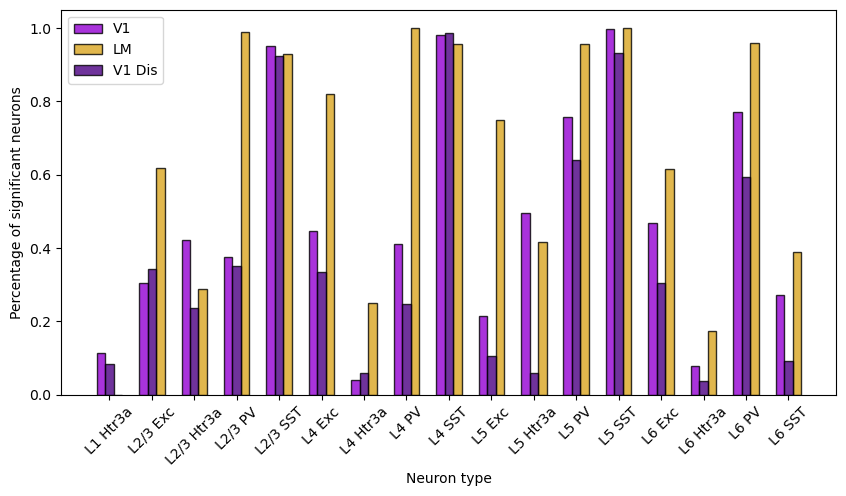

In [14]:
# apply it also to the neuron types
significant_cell_types_v1 = [cell_types_v1[neuron] for neuron in significant_neurons_v1]
significant_cell_types_lm = [cell_types_lm[neuron] for neuron in significant_neurons_lm]
significant_cell_types_v1_dis = [cell_types_v1[neuron] for neuron in significant_neurons_v1_dis]

# compute the percentage of significant neurons in each neuron type
percentage_v1 = np.zeros(len(unique_cell_types))
percentage_lm = np.zeros(len(unique_cell_types))
percentage_v1_dis = np.zeros(len(unique_cell_types))

for type in unique_cell_types:
    # count number of type in cell_types_v1
    n_type_v1 = cell_types_v1.count(type)
    n_type_lm = cell_types_lm.count(type)
    n_type_v1_dis = cell_types_v1.count(type)

    # count number of type in significant_cell_types_v1
    n_type_significant_v1 = significant_cell_types_v1.count(type)
    n_type_significant_lm = significant_cell_types_lm.count(type)
    n_type_significant_v1_dis = significant_cell_types_v1_dis.count(type)

    # compute the percentage
    percentage_v1[unique_cell_types.index(type)] = n_type_significant_v1 / n_type_v1
    percentage_lm[unique_cell_types.index(type)] = n_type_significant_lm / n_type_lm
    percentage_v1_dis[unique_cell_types.index(type)] = n_type_significant_v1_dis / n_type_v1_dis


# plot the percentage of significant neurons in each neuron type
plt.figure(figsize = (10,5))
bar_width = 0.2  # Define the width of the bars
x = np.arange(len(unique_cell_types))  # Define the x-coordinates of the bars

plt.bar(x - bar_width, percentage_v1, bar_width, color='darkviolet', label='V1', alpha=0.8, edgecolor='black')
plt.bar(x + bar_width, percentage_lm, bar_width, color='goldenrod', label='LM', alpha=0.8, edgecolor='black')
plt.bar(x , percentage_v1_dis, bar_width, color='indigo', label='V1 Dis', alpha=0.8, edgecolor='black')

plt.xticks(x, unique_cell_types, rotation=45)   # Set the x-ticks to the middle of the bars
plt.xlabel('Neuron type')
plt.ylabel('Percentage of significant neurons')
plt.legend()
plt.show()

# RF computation for all significant neurons

In [15]:
# Filter the rf_areas_v1 and rf_areas_lm with the significant neurons
rf_areas_v1_significant = rf_areas_v1[significant_neurons_v1]
rf_areas_lm_significant = rf_areas_lm[significant_neurons_lm]
rf_areas_v1_dis_significant = rf_areas_v1_dis[significant_neurons_v1_dis]

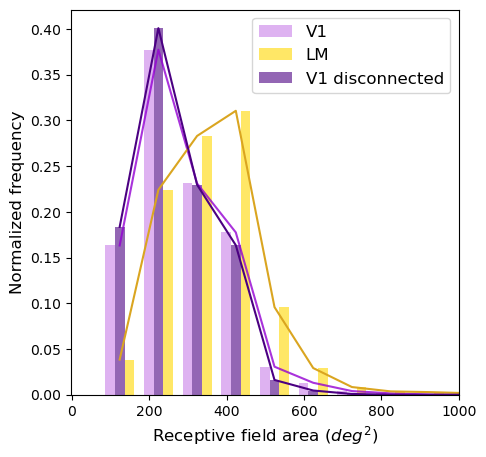

Median V1 RF area: 200.0
Median LM RF area: 300.0
Median V1 disconnected RF area: 200.0

Mean V1 RF area: 260.7168983174835
Mean LM RF area: 338.6637675429927
Mean V1 disconnected RF area: 244.88450916394677

5 and 95 percentiles for V1: 100.0 500.0
5 and 95 percentiles for LM: 200.0 500.0
5 and 95 percentiles for V1 disconnected: 100.0 400.0

Mean V1 RF area inside 0.05 and 0.95 percentiles: 274.58121355006824
Mean LM RF area inside 0.05 and 0.95 percentiles: 352.31435231435233
Mean V1 disconnected RF area inside 0.05 and 0.95 percentiles: 236.42245669918375

Mean removing large outliers (>75 percentile):
Mean V1 RF area: 244.55460803452172
Mean LM RF area: 301.0849492151431
Mean V1 disconnected RF area: 205.65877727237685


In [36]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_v1_dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (5,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize=12)
plt.ylabel('Normalized frequency', fontsize=12)
plt.xlim(-1, 1000)
plt.legend(fontsize = 12)

# compute percentiles 5 and 95 for V1 and LM
q1_v1 = np.percentile(rf_areas_v1_significant, 5)
q3_v1 = np.percentile(rf_areas_v1_significant, 95)
q1_lm = np.percentile(rf_areas_lm_significant, 5)
q3_lm = np.percentile(rf_areas_lm_significant, 95)
q1_v1dis = np.percentile(rf_areas_v1_dis_significant, 5)
q3_v1dis = np.percentile(rf_areas_v1_dis_significant, 95)

# # plot the quartiles
# plt.axvline(q1_v1, color='darkviolet', linestyle='--')
# plt.axvline(q3_v1, color='darkviolet', linestyle='--')
# plt.axvline(q1_lm, color='gold', linestyle='--')
# plt.axvline(q3_lm, color='gold', linestyle='--')

plt.show()

# compute the median
median_v1 = np.median(rf_areas_v1_significant)
median_lm = np.median(rf_areas_lm_significant)
median_v1dis = np.median(rf_areas_v1_dis_significant)

print('Median V1 RF area:', median_v1)
print('Median LM RF area:', median_lm)
print('Median V1 disconnected RF area:', median_v1dis)

# compute the mean
mean_v1 = np.mean(rf_areas_v1_significant)
mean_lm = np.mean(rf_areas_lm_significant)
mean_v1dis = np.mean(rf_areas_v1_dis_significant)

print()
print('Mean V1 RF area:', mean_v1)
print('Mean LM RF area:', mean_lm)
print('Mean V1 disconnected RF area:', mean_v1dis)

# compute the mean inside the 5th and 95th percentiles
mean_v1 = np.mean(rf_areas_v1_significant[(rf_areas_v1_significant > q1_v1) & (rf_areas_v1_significant < q3_v1)])
mean_lm = np.mean(rf_areas_lm_significant[(rf_areas_lm_significant > q1_lm) & (rf_areas_lm_significant < q3_lm)])
mean_v1dis = np.mean(rf_areas_v1_dis_significant[(rf_areas_v1_dis_significant > q1_v1dis) & (rf_areas_v1_dis_significant < q3_v1dis)])

print()
print("5 and 95 percentiles for V1:", q1_v1, q3_v1)
print("5 and 95 percentiles for LM:", q1_lm, q3_lm)
print("5 and 95 percentiles for V1 disconnected:", q1_v1dis, q3_v1dis)

print()
print('Mean V1 RF area inside 0.05 and 0.95 percentiles:', mean_v1)
print('Mean LM RF area inside 0.05 and 0.95 percentiles:', mean_lm)
print('Mean V1 disconnected RF area inside 0.05 and 0.95 percentiles:', mean_v1dis)

# compute the mean leaving out the outliers larger than percentil 75
q75_v1 = np.percentile(rf_areas_v1_significant, 95)
q75_lm = np.percentile(rf_areas_lm_significant, 95)
q75_v1dis = np.percentile(rf_areas_v1_dis_significant, 95)

print()
print("Mean removing large outliers (>75 percentile):")
mean_v1 = np.mean(rf_areas_v1_significant[rf_areas_v1_significant < q75_v1])
mean_lm = np.mean(rf_areas_lm_significant[rf_areas_lm_significant < q75_lm])
mean_v1dis = np.mean(rf_areas_v1_dis_significant[rf_areas_v1_dis_significant < q75_v1dis])

print('Mean V1 RF area:', mean_v1)
print('Mean LM RF area:', mean_lm)
print('Mean V1 disconnected RF area:', mean_v1dis)

(-1.0, 1000.0)

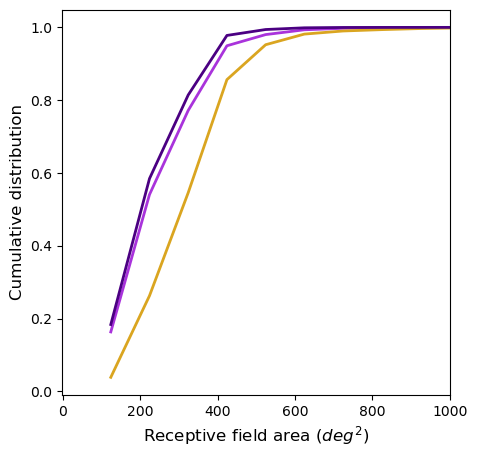

In [37]:
# Define bin edges and centers
plt.figure(figsize=(5,5))
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_v1_dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Calculate cumulative sums
cumsum_v1 = np.cumsum(hist_v1)
cumsum_lm = np.cumsum(hist_lm)
cumsum_v1_dis = np.cumsum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
# plt.figure(figsize = (7,5))
# plt.bar(bin_centers - width, cumsum_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
# plt.bar(bin_centers + width, cumsum_lm, width=width, color='gold', label='LM', alpha=0.6)
# plt.bar(bin_centers, cumsum_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], cumsum_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8, linewidth = 2)
plt.plot(bin_centers[hist_lm > 0], cumsum_lm[hist_lm > 0], color='goldenrod', linewidth = 2)
plt.plot(bin_centers[hist_v1_dis > 0], cumsum_v1_dis[hist_v1_dis > 0], color='indigo', linewidth = 2)

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize = 12)
plt.ylabel('Cumulative distribution', fontsize = 12)
plt.xlim(-1, 1000)
# plt.legend()

In [38]:
def get_bootstrap_95ci(M, measure_of_central_tendency, N=1000):
    n = int(len(M)/2)
    est = np.zeros((N,))
    for i in range(N):
        boot = M[np.random.permutation(len(M))[:n]]
        est[i] = measure_of_central_tendency(boot)
        
    return np.percentile(est,97.5) - np.nanmean(est)

# compute the 95% confidence interval for the mean
ci_v1 = get_bootstrap_95ci(rf_areas_v1_significant, np.mean)
ci_lm = get_bootstrap_95ci(rf_areas_lm_significant, np.mean)
ci_v1_dis = get_bootstrap_95ci(rf_areas_v1_dis_significant, np.mean)

print()
print('95% confidence interval for the mean V1:', ci_v1)
print('95% confidence interval for the mean LM:', ci_lm)
print('95% confidence interval for the mean V1 disconnected:', ci_v1_dis)


95% confidence interval for the mean V1: 1.6138314475224433
95% confidence interval for the mean LM: 3.8519968366942976
95% confidence interval for the mean V1 disconnected: 1.7109465227215708


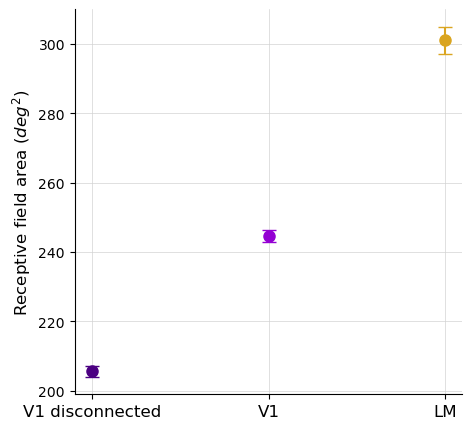

In [40]:
# Create a figure
plt.figure(figsize=(5,5))
x = ["V1 disconnected", "V1", "LM"]
colors = ['indigo', 'darkviolet', 'goldenrod']
y = [mean_v1dis, mean_v1, mean_lm]
errors = [ci_v1, ci_v1_dis, ci_lm]

for i in range(len(x)):
    plt.errorbar(x[i], y[i], yerr=errors[i], fmt='o', capsize=5, markersize=8, color=colors[i])

plt.ylabel(r'Receptive field area ($deg^2$)', fontsize = 12)

# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xticks(fontsize = 12)

plt.show()

# RF computation significant neurons by types

In [65]:
# update the layers mask to include only significant neurons
layer_mask_v1_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_v1] for i in range(len(unique_cell_types))]
layer_mask_lm_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_lm] for i in range(len(unique_cell_types))]
layer_mask_v1dis_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_v1_dis] for i in range(len(unique_cell_types))]

# Select the neuron type to filter
t = 13
type = unique_cell_types[t]
print("You have selected the type: ", type)

# select the given neuron type receptive field
rf_areas_type_v1_significant = rf_areas_v1_significant[layer_mask_v1_types_significant[t]]
rf_areas_type_lm_significant = rf_areas_lm_significant[layer_mask_lm_types_significant[t]]
rf_areas_type_v1dis_significant = rf_areas_v1_dis_significant[layer_mask_v1dis_types_significant[t]]

You have selected the type:  L6 Exc


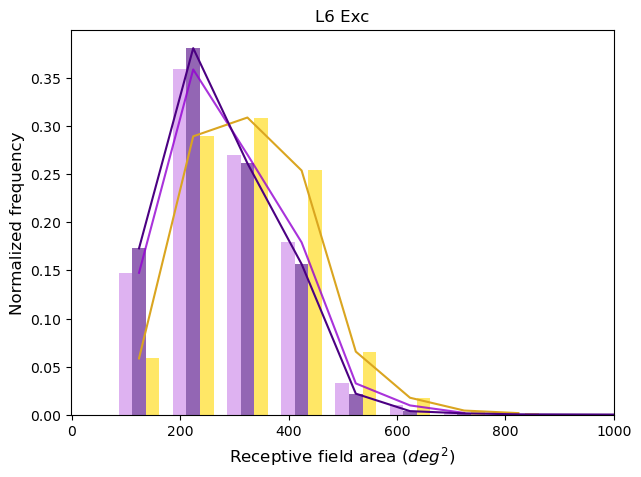

Median V1 RF area: 200.0
Median LM RF area: 300.0
Median V1 disconnected RF area: 200.0
Mean V1 RF area: 262.787617944049
Mean LM RF area: 305.8562555456965
Mean V1 disconnected RF area: 249.96168582375478


In [66]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_type_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_type_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_type_v1dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize = 12)
plt.ylabel('Normalized frequency', fontsize = 12)
plt.xlim(-1, 1000)
# put neuron type as title
plt.title(type)
# plt.legend()

# compute 5th and 95th percentiles
# q1_v1 = np.percentile(rf_areas_type_v1_significant, 5)
# q3_v1 = np.percentile(rf_areas_type_v1_significant, 95)
# q1_lm = np.percentile(rf_areas_type_lm_significant, 5)
# q3_lm = np.percentile(rf_areas_type_lm_significant, 95)

# plot the quartiles
# plt.axvline(q1_v1, color='darkviolet', linestyle='--')
# plt.axvline(q3_v1, color='darkviolet', linestyle='--')
# plt.axvline(q1_lm, color='gold', linestyle='--')
# plt.axvline(q3_lm, color='gold', linestyle='--')

plt.show()

# print the medians
print('Median V1 RF area:', np.median(rf_areas_type_v1_significant))
print('Median LM RF area:', np.median(rf_areas_type_lm_significant))
print('Median V1 disconnected RF area:', np.median(rf_areas_type_v1dis_significant))

# print the means
print('Mean V1 RF area:', np.mean(rf_areas_type_v1_significant))
print('Mean LM RF area:', np.mean(rf_areas_type_lm_significant))
print('Mean V1 disconnected RF area:', np.mean(rf_areas_type_v1dis_significant))

# # compute the mean inside the 5th and 95th percentiles
# mean_v1 = np.mean(rf_areas_type_v1_significant[(rf_areas_type_v1_significant > q1_v1) & (rf_areas_type_v1_significant < q3_v1)])
# mean_lm = np.mean(rf_areas_type_lm_significant[(rf_areas_type_lm_significant > q1_lm) & (rf_areas_type_lm_significant < q3_lm)])
# mean_v1dis = np.mean(rf_areas_type_v1dis_significant[(rf_areas_type_v1dis_significant > q1_v1) & (rf_areas_type_v1dis_significant < q3_v1)])

# print('\n Mean V1 RF area inside 0.05 and 0.95 percentiles:', mean_v1)
# print('Mean LM RF area inside 0.05 and 0.95 percentiles:', mean_lm)
# print('Mean V1 disconnected RF area inside 0.05 and 0.95 percentiles:', mean_v1dis)

In [68]:
# compute bootstrap 95% confidence interval for the mean
ci_v1 = get_bootstrap_95ci(rf_areas_type_v1_significant, np.mean)
ci_lm = get_bootstrap_95ci(rf_areas_type_lm_significant, np.mean)
ci_v1_dis = get_bootstrap_95ci(rf_areas_type_v1dis_significant, np.mean)

print()
print('95% confidence interval for the mean V1:', ci_v1)
print('95% confidence interval for the mean LM:', ci_lm)
print('95% confidence interval for the mean V1 disconnected:', ci_v1_dis)


95% confidence interval for the mean V1: 2.7624503311258763
95% confidence interval for the mean LM: 6.523978685612747
95% confidence interval for the mean V1 disconnected: 3.4048032703116746


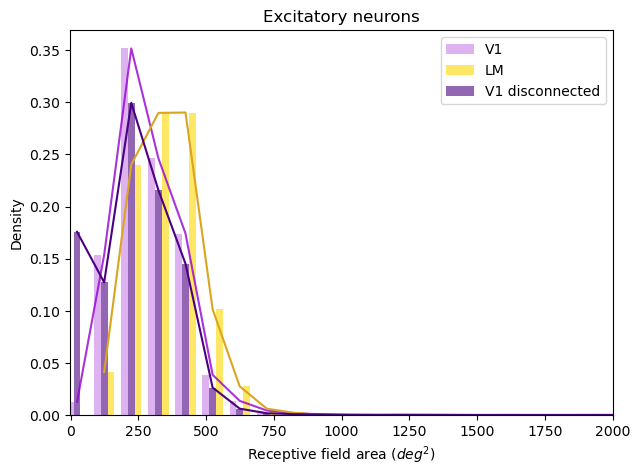

Median V1 RF area: 200.0
Median LM RF area: 300.0
Median V1 disconnected RF area: 200.0
Mean V1 RF area: 264.80111932840293
Mean LM RF area: 329.45563012677104
Mean V1 disconnected RF area: 215.82931865106676

 Mean V1 RF area inside 0.05 and 0.95 percentiles: 277.01107775132
Mean LM RF area inside 0.05 and 0.95 percentiles: 350.03213367609254
Mean V1 disconnected RF area inside 0.05 and 0.95 percentiles: 213.77168558577853


In [273]:
# Now do it for all excitatory neurons together: L2/3 Exc, L4 Exc, L5 Exc, L6 Exc
types = [1, 5, 9, 13]

rf_areas_exc_v1 = np.zeros((0))
rf_areas_exc_lm = np.zeros((0))
rf_areas_exc_v1dis = np.zeros((0))

for t in types:
    rf_areas_exc_v1 = np.concatenate((rf_areas_exc_v1, rf_areas_v1_significant[layer_mask_v1_types_significant[t]]))
    rf_areas_exc_lm = np.concatenate((rf_areas_exc_lm, rf_areas_lm_significant[layer_mask_lm_types_significant[t]]))
    rf_areas_exc_v1_dis = np.concatenate((rf_areas_exc_v1dis, rf_areas_v1_dis_significant[layer_mask_v1dis_types_significant[t]]))

# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_exc_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_exc_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_exc_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title('Excitatory neurons')
plt.legend()

# compute percentile 5 and 95
q1_v1 = np.percentile(rf_areas_exc_v1, 5)
q3_v1 = np.percentile(rf_areas_exc_v1, 95)
q1_lm = np.percentile(rf_areas_exc_lm, 5)
q3_lm = np.percentile(rf_areas_exc_lm, 95)
q1_v1dis = np.percentile(rf_areas_exc_v1_dis, 5)
q3_v1dis = np.percentile(rf_areas_exc_v1_dis, 95)

# plot the quartiles
# plt.axvline(q1_v1, color='darkviolet', linestyle='--')
# plt.axvline(q3_v1, color='darkviolet', linestyle='--')
# plt.axvline(q1_lm, color='gold', linestyle='--')
# plt.axvline(q3_lm, color='gold', linestyle='--')

plt.show()

# print the medians
print('Median V1 RF area:', np.median(rf_areas_exc_v1))
print('Median LM RF area:', np.median(rf_areas_exc_lm))
print('Median V1 disconnected RF area:', np.median(rf_areas_exc_v1_dis))

# print the averages
print('Mean V1 RF area:', np.mean(rf_areas_exc_v1))
print('Mean LM RF area:', np.mean(rf_areas_exc_lm))
print('Mean V1 disconnected RF area:', np.mean(rf_areas_exc_v1_dis))

# print the mean inside the 5th and 95th percentiles
mean_v1 = np.mean(rf_areas_exc_v1[(rf_areas_exc_v1 > q1_v1) & (rf_areas_exc_v1 < q3_v1)])
mean_lm = np.mean(rf_areas_exc_lm[(rf_areas_exc_lm > q1_lm) & (rf_areas_exc_lm < q3_lm)])
mean_v1dis = np.mean(rf_areas_exc_v1_dis[(rf_areas_exc_v1_dis > q1_v1dis) & (rf_areas_exc_v1_dis < q3_v1dis)])

print('\n Mean V1 RF area inside 0.05 and 0.95 percentiles:', mean_v1)
print('Mean LM RF area inside 0.05 and 0.95 percentiles:', mean_lm)
print('Mean V1 disconnected RF area inside 0.05 and 0.95 percentiles:', mean_v1dis)

